# ODIR5K: EDA, keyphrases, image sorting

In this notebook, I performed a superficial exploratory data analysis, investigated the relationship between diagnostic keyphrases and diagnosed conditions and, based on the latter, implemented some code to sort images of retinal fundi, according to conditions whose symptoms they display.

In [1]:
# Import everything we need

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, image as mpimg
from tqdm import tqdm
from time import time
from collections import Counter
import random

from skimage.transform import resize

import re

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, utils, callbacks
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Set up all the paths

train_dir = './OcularD/ODIR-5K/ODIR-5K/Training Images'
test_dir = './OcularD/ODIR-5K/ODIR-5K/Testing Images'
main_dir = './OcularD/ODIR-5K/ODIR-5K/'
work_dir = './'

First, let's load our data to a DataFrame and take a look at it

In [5]:
data = pd.read_excel(os.path.join(main_dir,'data.xlsx'), sheet_name=None)
data = pd.DataFrame(data[list(data.keys())[0]])

data

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


# Basic Exploratory Data Analysis

Let's now take parts of the data, which we can easily express numerically and look at their their distribution

s:\IVP_Project\Alcon\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


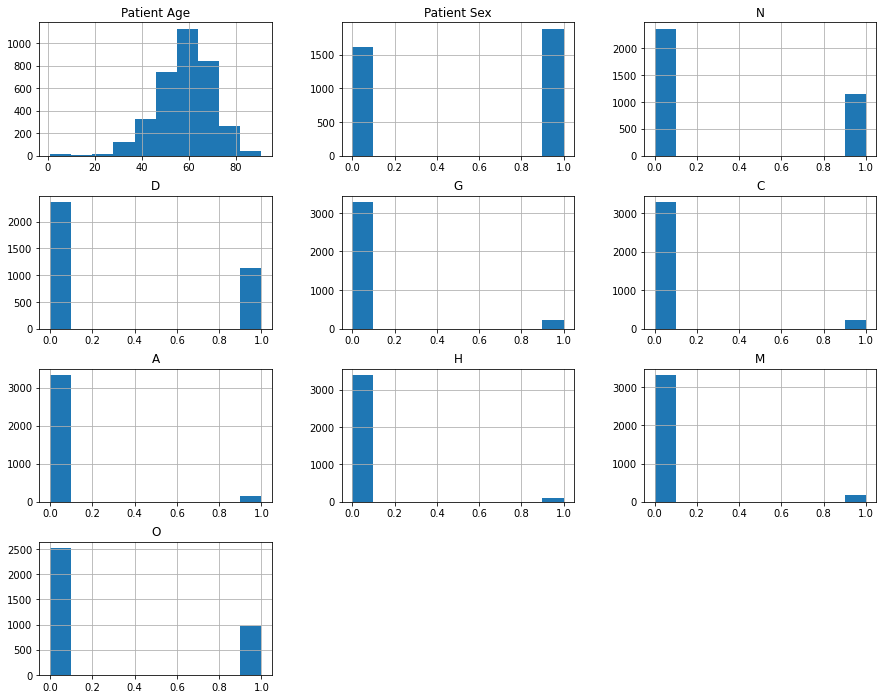

In [6]:
data_num = data.copy()[['Patient Age', 'Patient Sex', 'N', 'D','G','C','A','H','M','O']]
data_num['Patient Sex'] = data_num['Patient Sex'].apply(lambda x:0  if x=='Female' else 1) # we encode sex: Female => 0; Male => 1

data_num.hist(figsize=(15,12))

plt.show()

We can see a few interesting things here:

1) The most prominent age group are people in about their 60s.

2) There is slightly more males than females.

3) Most patients are not healthy, but healthy patients are the most prevalent of all groups.

4) The most prevalent non-healthy group are patients with diabetes, with "other" coming right after them.

* Since this "other" category likely lumps many non-related and quite heterogenous conditions, it's going to be more efficient to focus on diabetic patients.

* For now, we will build a model which will discriminate healthy retinas from those displaying signs of diabetes. Later we will test its performance how it performs on the images of retinas with signs of other diseases and see whether we can gain some insight from it.

One more thing: let's take a peek at correlations

In [7]:
data_num_corr = data_num.corr()
data_num_corr

,Patient Age,Patient Sex,N,D,G,C,A,H,M,O
Patient Age,1.000000,-0.087703,-0.073049,-0.080539,0.097791,0.186160,0.058005,-0.024944,-0.013635,0.067764
Patient Sex,-0.087703,1.000000,0.035501,0.027582,0.021977,-0.060492,-0.000883,0.032309,-0.078345,-0.036086
N,-0.073049,0.035501,1.000000,-0.479285,-0.177807,-0.176481,-0.154101,-0.121023,-0.158968,-0.433113
D,-0.080539,0.027582,-0.479285,1.000000,-0.094946,-0.075154,-0.106614,0.042701,-0.104288,-0.017049
G,0.097791,0.021977,-0.177807,-0.094946,1.000000,-0.049996,0.005212,0.011778,-0.020193,-0.029528
C,0.186160,-0.060492,-0.176481,-0.075154,-0.049996,1.000000,-0.056300,-0.030041,-0.058079,-0.075515
A,0.058005,-0.000883,-0.154101,-0.106614,0.005212,-0.056300,1.000000,-0.006610,-0.032053,-0.089978
H,-0.024944,0.032309,-0.121023,0.042701,0.011778,-0.030041,-0.006610,1.000000,-0.039828,-0.063315
M,-0.013635,-0.078345,-0.158968,-0.104288,-0.020193,-0.058079,-0.032053,-0.039828,1.000000,-0.013677
O,0.067764,-0.036086,-0.433113,-0.017049,-0.029528,-0.075515,-0.089978,-0.063315,-0.013677,1.000000


1) There is a small negative correlation between age and sex. Arbitrarily, we encoded males as 1s and females as 0s. If we did the opposite, the correlation would be of the same magnitude, but positive. This means that males in our data are little younger than females.

2) Older people seem to be more likely to develop in their retinas signs of glaucoma and cataract, but less likely to develop signs of diabetes. There does not seem to be any significant difference between sexes in susceptibility to any disease (or lack thereof).

3) Being 'Normal' correlates negatively with any other condition. That's what we would expect, since a patient can only be classified as 'Normal' if they weren't diagnosed as having any other condition.

4) What about between-disease correlation? Let's prune our correlation matrix, to make it easier to read. We will (again, a little arbitrarily), set the cutoff point for a meaningful correlation at the absolute value of 0.08.

In [8]:
cutoff = .08
data_disease_corr = data_num_corr.iloc[3:,3:].copy() # we cut off everything, except the information about correlation between specific conditions
data_disease_corr = data_disease_corr.applymap(lambda x:np.NaN if abs(x)<cutoff or x==1 else x ).round(2) # we set a cutoff point at .08 and round data to the second decimal point
data_disease_corr

,D,G,C,A,H,M,O
D,NaN,-0.09,NaN,-0.11,NaN,-0.1,NaN
G,-0.09,NaN,NaN,NaN,NaN,NaN,NaN
C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,-0.11,NaN,NaN,NaN,NaN,NaN,-0.09
H,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M,-0.10,NaN,NaN,NaN,NaN,NaN,NaN
O,NaN,NaN,NaN,-0.09,NaN,NaN,NaN


1) Diabetes correlates negatively with glaucoma, AMD and myopia

2) AMD correlates negatively with 'other diseases'

These are all, however, very small correlations, so they don't necesserily have to point to anything interesting. If there is some 'protective effect', it's probably due to patients with already existing condition taking more care of their eyes.

> Let's now see how many of our patients have more than one disease diagnosed

In [9]:
data_diseases = data.iloc[:,-7:].copy() # a slice of data containing only information about diseases occuring in each patient
disease_counter = Counter()
for i, row in data_diseases.iterrows():
    disease_counter[row.sum()]+=1
disease_counter

Counter({1: 1774, 0: 1140, 2: 557, 3: 29})

# Linguistic Exploratory Data Analysis: Keyphrases

Over half of alls our patients (1774 out of 3500) have exactly one disease diagnosed in at least one of their eyes. 1140 are healthy in both eyes. Note that if we included the 'N' column in data_diseases DataFrame, there would be no '0-cases' because the corresponding rows would have 1 in their 'N' columns, so we would have '1: 2914' instead of '1: 1774, 0: 1140'.

557 patients have exactly two conditions diagnosed and 29 have three.

This points to an important problem. If a patient was diagnosed not only with diabetes, but also with some other condition, how can we know the following:

1) Which one of their eyes displays symptoms of diabetes and which one displays symptoms of the other disease.

2) Or, maybe, one of their eyes is affected with both conditions, but the other one displays symptoms of only one or even seems completely healthy.

3) Even without more than one condition coexisting in a patient, we need to know, if only one eye of our diabetic patient shows symptoms of diabetes, or maybe it's both of them.

Unfortunately, such information is not contained explicitly in the last eight columns alone. We need to extract it from the keywords column.

Actually, it seems that columns 'Left-Diagnosis Keywords' and 'Right-Diagnosis Keywords' contain diagnostic keyphrases (ordered sequences of words) rather than individual meaningful keywords. These keyphrases are separated with commas, so it will probably be more efficient to treat them (and not the individual words) as individual tokens conveying information about diagnosis.

In [10]:
# Let's create a dictionary to store information about keyphrases used in the diagnosis for each disease and the frequency of their usage
conditions = list(data.columns[-8:])
conditions_keyphrases = {condition: Counter() for condition in conditions}

for i, row in data.iterrows():
    # Keyphrases used in the diagnosis for each eye:
    keyphrases = list(set(row['Left-Diagnostic Keywords'].replace('，',',').split(',') + row['Right-Diagnostic Keywords'].replace('，',',').split(',')))
        # Keyphrases are both split with an ordinary comma (',') and a 'weird' comma ('，'), so we replace all the cases in which the latter occurs with the first one
        #  and only then split the string of keywords into keyphrases. We turn it into a set to eliminate any doubles and then into a list again because we may want to
        #  use some list-specific methods, unavailable for sets. 
    
    # For every condition diagnosed
    for condition in conditions:
        if row[condition]==1:
            # Add 1 to the counter for the keyphrases present
            for keyphrase in keyphrases:
                conditions_keyphrases[condition][keyphrase] += 1

# Sort the dictionary for each condition in the descending order:
def dicsort(d):
    d_items_rev = [ (value, key) for (key, value) in d.items() ]
    d_items_sorted = [ (key, value) for (value, key) in sorted(d_items_rev, reverse=True) ]
    d_sorted = {key: value for (key, value) in d_items_sorted}
    return d_sorted

conditions_keyphrases = {condition: dicsort(conditions_keyphrases[condition]) for condition in conditions_keyphrases.keys()}

conditions_keyphrases

{'N': {'normal fundus': 1139, 'lens dust': 136, 'low image quality': 2},
 'D': {'moderate non proliferative retinopathy': 662,
  'mild nonproliferative retinopathy': 456,
  'normal fundus': 257,
  'severe nonproliferative retinopathy': 101,
  'macular epiretinal membrane': 61,
  'epiretinal membrane': 59,
  'laser spot': 54,
  'hypertensive retinopathy': 45,
  'cataract': 39,
  'lens dust': 35,
  'diabetic retinopathy': 33,
  'myelinated nerve fibers': 29,
  'drusen': 26,
  'proliferative diabetic retinopathy': 20,
  'glaucoma': 20,
  'vitreous degeneration': 19,
  'pathological myopia': 18,
  'low image quality': 16,
  'white vessel': 13,
  'suspected glaucoma': 12,
  'severe proliferative diabetic retinopathy': 10,
  'post retinal laser surgery': 9,
  'dry age-related macular degeneration': 9,
  'branch retinal vein occlusion': 8,
  'wet age-related macular degeneration': 6,
  'spotted membranous change': 6,
  'refractive media opacity': 5,
  'epiretinal membrane over the macula': 5,

Clearly, there are some keyphrases highly indicative of each condition:

Normal: normal fundus

Diabetes: moderate, mild or severe nonproliferative retinopathy
    
Glaucoma: glaucoma

Cataract: cataract

AMD: dry/wet age-related macular degeneration

Hypertension: hypertensive retinopathy

Myopia: pathological myopia

Other: well..., that's a mess, but that should be expected

However, the above code allows for quite a substantial amount of keyphrase cross-pollination. If a patient is diagnosed with more than one condition, then each of these conditions will be ascribed keyphrase(s) characteristic of the other.

Also, the above code mixes the diagnoses for both eyes, treating them as one unit, which is definitely not preferable. Since, there are separate columns for keywords from diagnoses of left and right eye, we would expect that states of the left and the right eye may be quite different.

To handle both of these problems that, we run a modified code, which extracts keyphrases in the exact same way, but exclusively from patients with only one condition diagnosed.

Also, to see, whether we significantly skimmed out dictionary, we will save the size of each of its entries (i.e. number of keyphrases for each condition) and number of occurences of all keyphrases for each condition:

In [11]:
conditions_keyphrases_metadata_1 = {
    'n_keyphrases': {condition: len(conditions_keyphrases[condition]) for condition in conditions_keyphrases.keys()},
    'n_occurences': {condition: np.sum(list(conditions_keyphrases[condition].values())) for condition in conditions_keyphrases.keys()}
}

conditions_keyphrases_metadata_1

{'n_keyphrases': {'N': 3,
  'D': 62,
  'G': 39,
  'C': 20,
  'A': 22,
  'H': 23,
  'M': 27,
  'O': 91},
 'n_occurences': {'N': 1277,
  'D': 2085,
  'G': 400,
  'C': 373,
  'A': 259,
  'H': 178,
  'M': 298,
  'O': 2150}}

In [12]:
conditions_keyphrases = {condition: Counter() for condition in conditions}

for i, row in data.iterrows():
    # If there was only one condition diagnosed, ('N' included) which one is it?
    if row.iloc[-8:].sum()==1:
        condition = row.index[len(row.index)-8 + row.iloc[-8:].astype(np.int32).argmax()]
        # Keyphrases used in the diagnosis for each eye
        keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
        keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
        keyphrases = []    
        # If this patient was not diagnosed as healthy
        if condition!='N':
            # If this eye was not diagnosed as healthy, add its diagnostic keyphrases to the list of keyphrases
            if 'normal fundus' not in keyphrases_L:
                keyphrases += keyphrases_L
            if 'normal fundus' not in keyphrases_R:
                keyphrases += keyphrases_R
        # If this patient was diagnosed as healthy, then both of his eyes should be ascribed to category 'N'
        else:
            keyphrases += keyphrases_L + keyphrases_R

        # Add the keyphrases to the conditions_keyphrases dictionary:
        for keyphrase in keyphrases:
            conditions_keyphrases[condition][keyphrase] += 1


conditions_keyphrases = {condition: dicsort(conditions_keyphrases[condition]) for condition in conditions_keyphrases.keys()}

conditions_keyphrases_metadata_2 = {
    'n_keyphrases': {condition: len(conditions_keyphrases[condition]) for condition in conditions_keyphrases.keys()},
    'n_occurences': {condition: np.sum(list(conditions_keyphrases[condition].values())) for condition in conditions_keyphrases.keys()}
}

Let's now compare the outcomes of the two methods:

In [13]:
print('\tInclusive, cross-pollination-prone method:')
print('n_keyphrases:')
print(conditions_keyphrases_metadata_1['n_keyphrases'])
print('n_occurences:')
print(conditions_keyphrases_metadata_1['n_occurences'])

print('\n')

print('\tExclusive, cross-pollination-resistant method:')
print('n_keyphrases:')
print(conditions_keyphrases_metadata_2['n_keyphrases'])
print('n_occurences:')
print(conditions_keyphrases_metadata_2['n_occurences'])

	Inclusive, cross-pollination-prone method:
n_keyphrases:
{'N': 3, 'D': 62, 'G': 39, 'C': 20, 'A': 22, 'H': 23, 'M': 27, 'O': 91}
n_occurences:
{'N': 1277, 'D': 2085, 'G': 400, 'C': 373, 'A': 259, 'H': 178, 'M': 298, 'O': 2150}


	Exclusive, cross-pollination-resistant method:
n_keyphrases:
{'N': 3, 'D': 9, 'G': 4, 'C': 2, 'A': 2, 'H': 1, 'M': 5, 'O': 55}
n_occurences:
{'N': 2502, 'D': 1189, 'G': 204, 'C': 256, 'A': 216, 'H': 72, 'M': 193, 'O': 756}


The second one is clearly much more preferable. For each condition, we found a smaller, probably much more condition-specific set of diagnostic keyphrases. Let's take a look at it:

In [14]:
conditions_keyphrases

{'N': {'normal fundus': 2277, 'lens dust': 222, 'low image quality': 3},
 'D': {'moderate non proliferative retinopathy': 624,
  'mild nonproliferative retinopathy': 383,
  'severe nonproliferative retinopathy': 142,
  'low image quality': 16,
  'proliferative diabetic retinopathy': 14,
  'severe proliferative diabetic retinopathy': 4,
  'diabetic retinopathy': 4,
  'optic disk photographically invisible': 1,
  'no fundus image': 1},
 'G': {'glaucoma': 184,
  'suspected glaucoma': 14,
  'optic disk photographically invisible': 3,
  'lens dust': 3},
 'C': {'cataract': 235, 'lens dust': 21},
 'A': {'dry age-related macular degeneration': 182,
  'wet age-related macular degeneration': 34},
 'H': {'hypertensive retinopathy': 72},
 'M': {'pathological myopia': 182,
  'myopic retinopathy': 4,
  'lens dust': 4,
  'myopic maculopathy': 2,
  'anterior segment image': 1},
 'O': {'drusen': 130,
  'macular epiretinal membrane': 120,
  'epiretinal membrane': 110,
  'myelinated nerve fibers': 58,
  

Having obtained proper diagnostic keyphrases for each class, we can now calculate:

1) The frequency of each keyphrase occurring in each category (including cases of patients with more than one condition).

2) Condition-specifity of each keyphrase.

In [15]:
# A dictionary which will contain a frequency of keyphrases occuring within each condition (i.e. what fraction of cases within each condition had a given keyphrase)
conditions_keyphrases_freq = conditions_keyphrases.copy()
for condition in conditions_keyphrases_freq:
    for keyphrase in conditions_keyphrases_freq[condition]:
        conditions_keyphrases_freq[condition][keyphrase] = 0
        
conditions_counter = Counter() # Counter for number of individual images displaying signs of each condition

for i, row in data.iterrows():
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    for condition in conditions:
        # If at least one eye of this patient has the following condition
        if row[condition]==1:
            # If any keyphrase characteristic of this condition was found in the diagnostic keyphrases for the left eye...
            if any (keyphrase in keyphrases_L for keyphrase in conditions_keyphrases_freq[condition]):
                # ...then we can assume that this eye displays symptoms of this condition. We add 1 to the counter for cases of this condition.
                conditions_counter[condition] += 1
                # For any keyphrase used to describe it...
                for keyphrase in keyphrases_L:
                    # ...we check if it is associated with this condition. If it is, we add 1 to the counter for occurences of keyphrases for this condition.
                    if keyphrase in conditions_keyphrases_freq[condition]:
                        conditions_keyphrases_freq[condition][keyphrase] += 1 
            # We repeat the same for the right eye:
            if any (keyphrase in keyphrases_R for keyphrase in conditions_keyphrases_freq[condition]):
                conditions_counter[condition] += 1
                for keyphrase in keyphrases_R:
                    if keyphrase in conditions_keyphrases_freq[condition]:
                        conditions_keyphrases_freq[condition][keyphrase] += 1
    
# To obtain percentages, we divide each keyphrase count by the number of cases of the condition (i.e. individual eyes displaying characteristic symptoms)
for condition in conditions_keyphrases_freq:
    for keyphrase in conditions_keyphrases_freq[condition]:
        conditions_keyphrases_freq[condition][keyphrase] = np.round(conditions_keyphrases_freq[condition][keyphrase]/conditions_counter[condition], 3)

# Sorting:
conditions_keyphrases_freq = {condition: dicsort(conditions_keyphrases_freq[condition]) for condition in conditions_keyphrases_freq}

conditions_keyphrases_freq

{'N': {'normal fundus': 0.999, 'lens dust': 0.097, 'low image quality': 0.001},
 'D': {'moderate non proliferative retinopathy': 0.55,
  'mild nonproliferative retinopathy': 0.304,
  'severe nonproliferative retinopathy': 0.089,
  'diabetic retinopathy': 0.031,
  'proliferative diabetic retinopathy': 0.014,
  'low image quality': 0.009,
  'severe proliferative diabetic retinopathy': 0.006,
  'optic disk photographically invisible': 0.001,
  'no fundus image': 0.001},
 'G': {'glaucoma': 0.832,
  'suspected glaucoma': 0.13,
  'lens dust': 0.065,
  'optic disk photographically invisible': 0.012},
 'C': {'cataract': 0.966, 'lens dust': 0.111},
 'A': {'dry age-related macular degeneration': 0.823,
  'wet age-related macular degeneration': 0.177},
 'H': {'hypertensive retinopathy': 1.0},
 'M': {'pathological myopia': 0.961,
  'lens dust': 0.027,
  'myopic retinopathy': 0.016,
  'myopic maculopathy': 0.012,
  'anterior segment image': 0.008},
 'O': {'macular epiretinal membrane': 0.162,
  'ep

# Keyphrases for image sorting

Let's now consider each condition separately:

Normal:
    
99.9% of N cases were described with the keyphrase 'normal fundus'. We can rather safely assume that the remaining 0.1% displayed some anomalies, which were not however, indicative of any disease (maybe 'lens dust'). Therefore, we can take 'normal fundus' keyphrase as characteristic of this class, as well as use it to find out, which one is not affected with a disease diagnosed in a patient, which was not diagnosed as healthy.

Diabetes:

If we add up all the counts of every kind of retinopathy associated with diabetes (nonproliferative/proliferative, mild/moderate/severe), we will obtain a score very close to 100%. Assuming that these keyphrases do not co-occur, we can treat them as characteristic of this class.

Glaucoma:

Even adding up all the numbers, we do not get 100%, so cases of glaucoma were probably also described with some keyphrases non-characteristic of this class. Nevertheless, 'glaucoma' keyphrase can be taken as characteristic of this class.

Cataract:

An overwhelming majority of cataract cases (although not all of them) were described with 'cataract' keyphrase, so we treat as characteristic of this class.

Age-related Macular Degeneration:

Counts of keyphrases 'dry age-related macular degeneration' and 'wet age-related macular degeneration' add up to exactly 100%, so we can treat them (or, more efficiently, a substring 'age-related macular degeneration') as characteristic of this class.

Hypertension:

'Hypertensive retinopathy' keyphrase occurred in 100% cases, so it can be treated as characteristic of this class.

Myopia:

Counts of keyphrases containing substring 'myopi' add up to about 99%, so we can treat this substring as characteristic of this class.

Other:

None of the keyphrases associated with this class achieved a significant majority, but in the next few cells we will see whether any of them can be treated as characteristic of this class.

However, note that the above code omits all healthy eyes with patients having been diagnosed with any disease. If one eye of a patient displayed symptoms of, say, diabetes, but the other looked perfectly healthy, the latter would not be counted as 'Normal'. We will need to take that into account, when we will perform image sorting.

Before we start sorting images, let's see how often each keyphrase occurs in diagnoses for every condition.

Because some images display symptoms of more than one disease, we cannot completely avoid cross-pollination without excluding all patients with more than one condition diagnosed.

Therefore, we will perform two separate analyses: 

    1) Excluding patients with more than one condition
    
    2) Including patients with more than one condition

We need to make a list of all keyphrases used to describe patients with only one condition.

By the way, let's see if there are any keyphrases used only to describe patients with more than one condition. These we need to extract directly from the relevant columns of the dataframe. 

In [16]:
all_keyphrases = []
for condition in conditions:
    all_keyphrases += [keyphrase for keyphrase in conditions_keyphrases_freq[condition] if keyphrase not in all_keyphrases]

keyphrases_from_columns = []
for keyphrases_L, keyphrases_R in zip(data['Left-Diagnostic Keywords'].values, data['Right-Diagnostic Keywords'].values):
    keyphrases_from_columns += [keyphrase for keyphrase in keyphrases_L.replace('，',',').split(',') if keyphrase not in keyphrases_from_columns]
    keyphrases_from_columns += [keyphrase for keyphrase in keyphrases_R.replace('，',',').split(',') if keyphrase not in keyphrases_from_columns]

len(all_keyphrases), len(keyphrases_from_columns)

(74, 102)

We missed 28 keyphrases, but that's ok, since they're probably not very informative.

Let's make separate dataframes for both analyses

In [17]:
def make_keyphrases_df():
    keyphrases_df = pd.DataFrame( {keyphrase: {condition: 0 for condition in conditions} for keyphrase in keyphrases_from_columns} ).T
    keyphrases_df['Predictive power'] = 0 # Predictive power - how many occurrences of this keyphrase were associated with the most frequent class
    return keyphrases_df

keyphrases_excl = make_keyphrases_df()
keyphrases_incl = make_keyphrases_df()
keyphrases_incl

,N,D,G,C,A,H,M,O,Predictive power
cataract,0,0,0,0,0,0,0,0,0
normal fundus,0,0,0,0,0,0,0,0,0
laser spot,0,0,0,0,0,0,0,0,0
moderate non proliferative retinopathy,0,0,0,0,0,0,0,0,0
branch retinal artery occlusion,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
suspected cataract,0,0,0,0,0,0,0,0,0
post retinal laser surgery,0,0,0,0,0,0,0,0,0
age-related macular degeneration,0,0,0,0,0,0,0,0,0
intraretinal microvascular abnormality,0,0,0,0,0,0,0,0,0


Now, let's fill these dataframes.

We will iterate over the rows of the original data and do the following:

1. Check whether this patient was diagnosed with only one condition. We will store it as a boolean valua (True or False) in only_one_condition variable.

2. Extract the keyphrases for both eyes, separately, the same way we did before.

3. For every condition this patient was diagnosed with, we check whether each of the eyes displays any symptoms characteristic of this condition.
    
    3.1. If it does, we add 1 to the proper cell in the dataframe for the inclusive condition.
    
    3.2. If this patient had only diagnosis, we add 1 to the proper cell in the dataframe for the exclusive condition as well.
    
    
Then, to calculate the predictive power of each keyphrase, we take the number of times it occurred in diagnoses for conditions it occurred in the most often and divide it by the total number of times it appeared in the dataset.

Since some keyphrases were not present in conditions_keyphrases dictionary (because they were not used to describe cases of patients with only one condition diagnosed) their predictive power gets set to NaN (because we tried to divide 0/0). To avoid this we may replace this NaNs with zeros or simply use the .apply() method.

In [18]:
# We reinitialize both DataFrames to avoid errors
keyphrases_excl = make_keyphrases_df()
keyphrases_incl = make_keyphrases_df()

for i, row in data.iterrows():
    # 1.
    only_one_condition = bool(row[-8:].sum()==1)
    # 2.
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    for condition in conditions:
        # 3.
        if row[condition]==1:
            # Left eye
            if any(keyphrase in keyphrases_L for keyphrase in conditions_keyphrases[condition]):
                for keyphrase in keyphrases_L:
                    # 3.1.
                    keyphrases_incl.loc[keyphrase, condition] += 1
                    # 3.2.
                    if only_one_condition:
                        keyphrases_excl.loc[keyphrase, condition] += 1
            # Right eye:
            if any(keyphrase in keyphrases_R for keyphrase in conditions_keyphrases[condition]):
                for keyphrase in keyphrases_R:
                    # 3.1.
                    keyphrases_incl.loc[keyphrase, condition] += 1
                    # 3.2.
                    if only_one_condition:
                        keyphrases_excl.loc[keyphrase, condition] += 1
            

keyphrases_excl['Predictive power'] = (keyphrases_excl.max(axis=1) / keyphrases_excl.sum(axis=1)).replace(np.NaN, 0)
keyphrases_incl['Predictive power'] = (keyphrases_incl.max(axis=1) / keyphrases_incl.sum(axis=1)).replace(np.NaN, 0)

In [19]:
keyphrases_excl

,N,D,G,C,A,H,M,O,Predictive power
cataract,0,0,0,235,0,0,0,0,1.000000
normal fundus,2277,0,3,9,0,0,1,43,0.975997
laser spot,0,0,0,0,0,0,0,9,1.000000
moderate non proliferative retinopathy,0,624,0,0,0,0,0,0,1.000000
branch retinal artery occlusion,0,0,0,0,0,0,0,3,1.000000
...,...,...,...,...,...,...,...,...,...
suspected cataract,0,0,0,0,0,0,0,0,0.000000
post retinal laser surgery,0,0,0,0,0,0,0,2,1.000000
age-related macular degeneration,0,0,0,0,0,0,0,0,0.000000
intraretinal microvascular abnormality,0,0,0,0,0,0,0,0,0.000000


Let's now make another DataFrame, which will selectively display the degree of specificity (predictive power) of each keyphrase and the class it is specific for, according to both exclusionary and inclusionary analysis. We will also include information, whether there is agreement between classes predicted using both approaches  agree and the difference between specificity calculated.

We will include only these keyphrases, which we took into account in the previous exploration.

In [20]:
keyphrases_specificity = pd.DataFrame(
    np.zeros(shape=(len(all_keyphrases), 6)),
    index = all_keyphrases,
    columns = ['condition (excl.)','specificity (excl.)', 'condition (incl.)', 'specificity (incl.)', 'condition specificity agreement','specificity discrepancy'],
    dtype='object'
)

for keyphrase, row in keyphrases_specificity.iterrows():
    row.iloc[0] = conditions[keyphrases_excl.loc[keyphrase,:].argmax()]
    row.iloc[1] = keyphrases_excl.loc[keyphrase, 'Predictive power']
    row.iloc[2] = conditions[keyphrases_incl.loc[keyphrase,:].argmax()]
    row.iloc[3] = keyphrases_incl.loc[keyphrase, 'Predictive power']
    row.iloc[4] = row.iloc[0]==row.iloc[2]
    row.iloc[5] = row.iloc[1]-row.iloc[3]
keyphrases_specificity

,condition (excl.),specificity (excl.),condition (incl.),specificity (incl.),condition specificity agreement,specificity discrepancy
normal fundus,N,0.975997,N,0.973077,True,0.00292
lens dust,N,0.639769,N,0.497758,True,0.142012
low image quality,D,0.761905,D,0.761905,True,0.0
moderate non proliferative retinopathy,D,1.0,D,0.799519,True,0.200481
mild nonproliferative retinopathy,D,1.0,D,0.86385,True,0.13615
...,...,...,...,...,...,...
optic discitis,O,1.0,O,1.0,True,0.0
macular coloboma,O,1.0,O,1.0,True,0.0
congenital choroidal coloboma,O,1.0,O,1.0,True,0.0
asteroid hyalosis,O,1.0,O,1.0,True,0.0


We see that 'normal fundus' keyphrase is over 97% specific, which means that in more than 2% of cases it was used to describe a retina displaying symptoms of some disease. We can see what that was, by looking at the previous dataframe.

In [21]:
keyphrases_incl.loc['normal fundus']

N                   2277.000000
D                      0.000000
G                      4.000000
C                      9.000000
A                      0.000000
H                      0.000000
M                      1.000000
O                     49.000000
Predictive power       0.973077
Name: normal fundus, dtype: float64

So there were 4 patients with glaucoma, 9 patients with cataract, 1 patient with myopia, and 49 with some 'other' condition, whose retinal fundi, although displaying symptoms of a disease, still seemed 'normal'? This does not seem right.

To make sure that we didn't make some kind of error, let's run code analogous to the one we used to fill our dataframes. This time, we will ask it to print keyphrases for patients diagnosed with glaucoma, cataract, myopia or 'other', in whose cases the 'normal fundus' keyphrase co-occurred with some disease-specific keyphrase.


In [22]:
suspicious_rows = []
for i, row in data.query('G==1 or C==1 or M==1 or O==1').iterrows():
    # 1.
    only_one_condition = bool(row[-8:].sum()==1)
    # 2.
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    if ('normal fundus' in keyphrases_L and len(keyphrases_L)!=1) or ('normal fundus' in keyphrases_R and len(keyphrases_R)!=1):
        suspicious_rows.append(row)
    
    
suspicious_rows = pd.DataFrame(suspicious_rows)
suspicious_rows

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
20,20,64,Female,20_left.jpg,20_right.jpg,rhegmatogenous retinal detachment,lens dust，normal fundus,0,0,0,0,0,0,0,1
36,36,55,Male,36_left.jpg,36_right.jpg,lens dust，spotted membranous change,lens dust，normal fundus,0,0,0,0,0,0,0,1
57,57,64,Male,57_left.jpg,57_right.jpg,lens dust，normal fundus,lens dust，drusen，normal fundus,0,0,0,0,0,0,0,1
70,70,57,Female,70_left.jpg,70_right.jpg,epiretinal membrane，lens dust,lens dust，normal fundus,0,0,0,0,0,0,0,1
80,80,50,Female,80_left.jpg,80_right.jpg,lens dust，normal fundus,lens dust，myelinated nerve fibers,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,2139,71,Male,2139_left.jpg,2139_right.jpg,lens dust，normal fundus,cataract,0,0,0,1,0,0,0,0
1619,2159,53,Male,2159_left.jpg,2159_right.jpg,cataract,lens dust，normal fundus,0,0,0,1,0,0,0,0
1637,2177,87,Male,2177_left.jpg,2177_right.jpg,normal fundus，lens dust,cataract,0,0,0,1,0,0,0,0
1665,2208,62,Male,2208_left.jpg,2208_right.jpg,normal fundus，lens dust,cataract,0,0,0,1,0,0,0,0


It seems that every time an eye with 'normal fundus' was classified by our program as displaying signs of glaucoma, cataract, myopia or 'other', it was due to the 'normal fundus' keyphrase co-occurring with 'lens dust' keyphrase. This seems plausible, since 'lens dust' was used in one-condition diagnoses for N, G, C, M, and O cases, but not D, H, and A, which were not associated with 'normal fundus'.

In [23]:
for condition in conditions:
    print(condition, 'lens dust' in conditions_keyphrases[condition].keys())

N True
D False
G True
C True
A False
H False
M True
O True


Thus, we used the 'lens dust' keyphrase as characteristic of each of these conditions, but since it was used to describe all of them, it's not appropriate to be used as a reliable diagnostic criterion for either. Looking at the data we have extracted, it's clear that it has a remarkably low specificity:

In [24]:
keyphrases_specificity.loc['lens dust']

condition (excl.)                         N
specificity (excl.)                0.639769
condition (incl.)                         N
specificity (incl.)                0.497758
condition specificity agreement        True
specificity discrepancy            0.142012
Name: lens dust, dtype: object

In [25]:
keyphrases_incl.loc['lens dust']

N                   222.000000
D                    22.000000
G                    22.000000
C                    36.000000
A                     0.000000
H                     0.000000
M                     7.000000
O                   137.000000
Predictive power      0.497758
Name: lens dust, dtype: float64

Therefore, we will prepare (manually) a list of diagnostic keyphrases for each condition. The problem is that we have no keyphrase characteristic of the class 'other', so we need to use an aggregate of keyphrases, each of which should be highly specific for this class, although occurring only in a small fraction (1/6 at most) of them.

We will make a separate dataframe, only for keyphrases associated with the 'other' class and add to it another column, which will tell us what fraction of all the 'O' cases had this keyphrase. We will also add information about the number of times this keyphrase was used to describe a case which was not assigned to this class.

In [26]:
keyphrases_O = keyphrases_incl.copy().loc[list(conditions_keyphrases['O'].keys())]
keyphrases_O['O-fraction'] = keyphrases_O['O'] / data['O'].sum()
keyphrases_O['non-O'] = 0

for i, row in data.query('O!=1').iterrows():
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    for keyphrase in keyphrases_O.index:
        if keyphrase in keyphrases_L or keyphrase in keyphrases_R:
            keyphrases_O.loc[keyphrase, 'non-O']+=1

keyphrases_O

,N,D,G,C,A,H,M,O,Predictive power,O-fraction,non-O
drusen,0,14,3,1,0,0,0,180,0.909091,0.183861,0
macular epiretinal membrane,0,49,8,0,2,2,0,201,0.767176,0.205312,0
epiretinal membrane,0,47,5,0,0,0,0,187,0.782427,0.191011,0
myelinated nerve fibers,0,21,4,2,0,0,0,99,0.785714,0.101124,0
vitreous degeneration,0,10,1,1,0,0,0,72,0.857143,0.073544,0
lens dust,222,22,22,36,0,0,7,137,0.497758,0.139939,170
refractive media opacity,0,1,4,0,0,0,4,63,0.875000,0.064351,0
spotted membranous change,0,3,0,0,0,0,0,30,0.909091,0.030644,0
maculopathy,0,1,1,0,0,1,0,28,0.903226,0.028601,0
retinal pigmentation,0,1,0,0,0,0,0,21,0.954545,0.021450,0


This seems great! Except for 'lens dust' and 'low image quality' all these keyphrases occurred only in cases of patients assigned an 'other' diagnosis (although often with other non-'other' conditions). Thus, we could treat all of them as characteristic of this class, but for the sake of efficiency we will restrict ourselves to those with the highest 'O-fraction' value.

Let's remove the two invalid keyphrases and sort this dataframe.

In [27]:
try:
    keyphrases_O.drop(['lens dust', 'low image quality'], axis=0, inplace=True)
except Exception as e:
    pass
keyphrases_O.sort_values(by='O-fraction', axis=0, inplace=True, ascending=False)
keyphrases_O

,N,D,G,C,A,H,M,O,Predictive power,O-fraction,non-O
macular epiretinal membrane,0,49,8,0,2,2,0,201,0.767176,0.205312,0
epiretinal membrane,0,47,5,0,0,0,0,187,0.782427,0.191011,0
drusen,0,14,3,1,0,0,0,180,0.909091,0.183861,0
myelinated nerve fibers,0,21,4,2,0,0,0,99,0.785714,0.101124,0
laser spot,0,78,3,3,0,0,0,95,0.530726,0.097038,0
vitreous degeneration,0,10,1,1,0,0,0,72,0.857143,0.073544,0
refractive media opacity,0,1,4,0,0,0,4,63,0.875000,0.064351,0
spotted membranous change,0,3,0,0,0,0,0,30,0.909091,0.030644,0
tessellated fundus,0,1,1,0,0,0,0,29,0.935484,0.029622,0
maculopathy,0,1,1,0,0,1,0,28,0.903226,0.028601,0


Although 'O-fraction' drops quite quickly from 0.205 at the first place to only 0.03 at the ninth, many of these keyphrases are going to co-occur, which can be clearly seen, if we add up all numbers in these column.

In [28]:
keyphrases_O['O-fraction'].sum()

1.2655771195097032

If they would not co-occur, we would expect them to add up to 1 (or very close).

I will go with my gut feeling at take the first 20 keyphrases. This seems to capture at least a significant amount of all the 'O' cases.

In [29]:
keyphrases_O_chosen = list(keyphrases_O.iloc[:20].index)
print(keyphrases_O.iloc[:20,-2].sum()) # O-fraction is the penultimate column

1.1756894790602659


So, our final set of diagnostic keyphrases is going to look as follows:

In [30]:
diagnostic_keyphrases = {
    'N' : ['normal fundus'],
    'D' : ['nonproliferative retinopathy', 'non proliferative retinopathy', 'proliferative retinopathy'],
    'G' : ['glaucoma'],
    'C' : ['cataract'],
    'A' : ['age-related macular degeneration'],
    'H' : ['hypertensive'],
    'M' : ['myopi'],
    'O' : keyphrases_O_chosen
}



Before moving on, let's see what keyphrases DataFrames we will obtain using this adjusted set of keyphrases.

In [31]:
# We reinitialize both DataFrames to avoid errors
keyphrases_excl_new = make_keyphrases_df()
keyphrases_incl_new = make_keyphrases_df()

for i, row in data.iterrows():
    # 1.
    only_one_condition = bool(row[-8:].sum()==1)
    # 2.
    keyphrases_L = row['Left-Diagnostic Keywords'].replace('，',',').split(',')
    keyphrases_R = row['Right-Diagnostic Keywords'].replace('，',',').split(',')
    for condition in conditions:
        # 3.
        if row[condition]==1:
            # Left eye
            if any(keyphrase in keyphrases_L for keyphrase in diagnostic_keyphrases[condition]):
                for keyphrase in keyphrases_L:
                    # 3.1.
                    keyphrases_incl_new.loc[keyphrase, condition] += 1
                    # 3.2.
                    if only_one_condition:
                        keyphrases_excl_new.loc[keyphrase, condition] += 1
            # Right eye:
            if any(keyphrase in keyphrases_R for keyphrase in diagnostic_keyphrases[condition]):
                for keyphrase in keyphrases_R:
                    # 3.1.
                    keyphrases_incl_new.loc[keyphrase, condition] += 1
                    # 3.2.
                    if only_one_condition:
                        keyphrases_excl_new.loc[keyphrase, condition] += 1
            

keyphrases_excl_new['Predictive power'] = (keyphrases_excl_new.max(axis=1) / keyphrases_excl_new.sum(axis=1)).replace(np.NaN, 0)
keyphrases_incl_new['Predictive power'] = (keyphrases_incl_new.max(axis=1) / keyphrases_incl_new.sum(axis=1)).replace(np.NaN, 0)

In [32]:
keyphrases_incl_new.loc['normal fundus']

N                   2277.000000
D                      0.000000
G                      0.000000
C                      0.000000
A                      0.000000
H                      0.000000
M                      0.000000
O                      3.000000
Predictive power       0.998684
Name: normal fundus, dtype: float64

Acceptably close to perfect

# Diagnostic keyphrases for image sorting: Testing time

Let's finally put our diagnostic keyphrases to the test, i.e. see how many images of fundi belonging to each class it will capture. We will compare these numbers to the total count of patients diagnosed with each condition in at least one of their eyes, although it's going to be an imperfect comparison, since this the original table itself does not tell us explicitly whether a given patient had only one eye affected with each disease diagnosed or both.

Once again, we are going to iterate over all the rows of dataframe. For each row:

1. If the patient was healthy ('N'), we add images of both of their eyes to the list of 'N' images and go to the next row.

2. Otherwise, we extract the keyphrases used to describe both retinal fundi.

3. We make the list of all the conditions this patient was diagnosed with.

4. If one of the eyes is healthy, this means, that all the conditions diagnosed affect the other eye. In such a case, we can add the former to the list of 'N' images and the latter to the lists of images for each condition diagnosed.

5. Otherwise (i.e. if neither eye is healthy), we re-iterate over these conditions and see whether diagnostic keyphrases specific for each of condition can be found in the keyphrases for each eye. If they do, we add this eye's image to the proper list.

In [33]:
fundi_images = {condition:[] for condition in conditions}

for i, row in data.iterrows():
    image_L = row['Left-Fundus']
    image_R = row['Right-Fundus']
    if row['N']==1:
        fundi_images['N'] += [image_L, image_R]
        continue
    
    # This time there is no need for splitting the keyphrases from strings into lists of keyphrases 
    keyphrases_L = row['Left-Diagnostic Keywords']
    keyphrases_R = row['Right-Diagnostic Keywords']

    diagnosed_conditions = []
    for condition in conditions[1:]:
        if row[condition]==1:
            diagnosed_conditions.append(condition)
            
    if 'normal fundus' in keyphrases_L:
        fundi_images['N'].append(image_L)
        for condition in diagnosed_conditions:
            fundi_images[condition].append(image_R)
        continue
    if 'normal fundus' in keyphrases_R:
        fundi_images['N'].append(image_R)
        for condition in diagnosed_conditions:
            fundi_images[condition].append(image_L)
        continue
    
    for condition in diagnosed_conditions:
        if any(keyphrase in keyphrases_L for keyphrase in diagnostic_keyphrases[condition]):
            fundi_images[condition].append(image_L)
        if any(keyphrase in keyphrases_R for keyphrase in diagnostic_keyphrases[condition]):
            fundi_images[condition].append(image_R)
            

Let's see see how many images for each condition we managed to aggregate, and how it compares to the number of patients diagnosed with this condition

In [34]:
for condition in conditions:
    print(condition, len(fundi_images[condition]), data[condition].sum())

N 3100 1140
D 1711 1128
G 326 215
C 313 212
A 280 164
H 193 103
M 268 174
O 1153 979


Seems good!

Over the 1140 healthy patients, with 2 * 1140 = 2280 healthy eyes, we have also 3100 - 2280 = 820 patients with exactly one healthy eye (or maybe with just a little bit of lens dust). About half of patients with glaucoma, cataract, AMBD, hypertension, and myopia seem to have both of their eyes affected. This fraction is closer to 1/6 for patients with 'other' conditions (of which many have one or two other conditions).

Let's see how many images we collected in all classes:

In [35]:
np.sum([len(fundi_images[condition]) for condition in conditions])

7344

Obviously, some images ended in more than one categories, so we could expect this number to be greater than the total number of all images in the dataset, which is 7000, especially if we managed to collect all or almost all of the images.

Let's see how many of these images ended up in more than one class and how frequent are specific correlations. This will also allow us to check the total number of *individual* images collected. 

In [36]:
fundi_images_rev = {}
for condition in conditions:
    for im in fundi_images[condition]:
        if im not in fundi_images_rev:
            fundi_images_rev[im] = [condition]
        else:
            fundi_images_rev[im] = sorted(fundi_images_rev[im]+[condition])
            
conditions_correlation = pd.DataFrame(np.zeros(shape=(7,7)), columns=conditions[1:], index=conditions[1:], dtype=np.int32)

for im in fundi_images_rev:
    if len(fundi_images_rev[im])>1:
        for i in range(len(fundi_images_rev[im])):
            for ii in range(len(fundi_images_rev[im])):
                if i!=ii:
                    
                    conditions_correlation.loc[fundi_images_rev[im][i],fundi_images_rev[im][ii]] += 1
    
conditions_correlation

,D,G,C,A,H,M,O
D,0,20,15,6,56,8,241
G,20,0,2,14,8,8,30
C,15,2,0,0,3,0,8
A,6,14,0,0,5,2,4
H,56,8,3,5,0,0,5
M,8,8,0,2,0,0,4
O,241,30,8,4,5,4,0


The most often occurring pair was 'other' and diabetes, with hypertension and diabetes coming at the second place, and 'other' and glaucoma at the third.

We can compare that to the multi-class cases in the original data. We should expect similar numbers, since this does not seem very likely that a patient would have symptoms of two diseases in both of their eyes.

In [37]:
print(data.query('D==1 & O==1').index.shape[0])
print(data.query('D==1 & H==1').index.shape[0])
print(data.query('G==1 & O==1').index.shape[0])

303
45
49


I suspect we missed some images from patients with 'other' conditions, which should be expected due to use of an incomplete list of diagnostic keyphrases. This would explain why there are more patients with diabetes and 'other' as well as with glaucoma and 'other' than the number of individual eye images, that we collected. The number of patients diagnosed with both diabetes and hypertension, on the other hand (45) is just a little lower than the number of individual images displaying symptomes of both these conditions. It could mean that 11 of these 45 patients have symptoms of their diseases present in both of their eyes.

Let's see how many individual images we've collected.

In [38]:
print('Total individual images: ', len(fundi_images_rev))

Total individual images:  6910


Just 93 short of the 7000 total. Let's see how it'll do if we use all the full set of diagnostic keyphrases for 'O'.

First, however, let's save how many images we collected per each class.

In [39]:
images_per_condition_1 = {}
for condition in conditions:
    images_per_condition_1[condition] = len(fundi_images[condition])
images_per_condition_1

{'N': 3100,
 'D': 1711,
 'G': 326,
 'C': 313,
 'A': 280,
 'H': 193,
 'M': 268,
 'O': 1153}

In [40]:
keyphrases_O_full = list(keyphrases_O.index)
diagnostic_keyphrases['O'] = keyphrases_O_full

fundi_images = {condition:[] for condition in conditions}

for i, row in data.iterrows():
    image_L = row['Left-Fundus']
    image_R = row['Right-Fundus']
    if row['N']==1:
        fundi_images['N'] += [image_L, image_R]
        continue
    
    # This time there is no need for splitting the keyphrases from strings into lists of keyphrases 
    keyphrases_L = row['Left-Diagnostic Keywords']
    keyphrases_R = row['Right-Diagnostic Keywords']

    diagnosed_conditions = []
    for condition in conditions[1:]:
        if row[condition]==1:
            diagnosed_conditions.append(condition)
            
    if 'normal fundus' in keyphrases_L:
        fundi_images['N'].append(image_L)
        for condition in diagnosed_conditions:
            fundi_images[condition].append(image_R)
        continue
    if 'normal fundus' in keyphrases_R:
        fundi_images['N'].append(image_R)
        for condition in diagnosed_conditions:
            fundi_images[condition].append(image_L)
        continue
    
    for condition in diagnosed_conditions:
        if any(keyphrase in keyphrases_L for keyphrase in diagnostic_keyphrases[condition]):
            fundi_images[condition].append(image_L)
        if any(keyphrase in keyphrases_R for keyphrase in diagnostic_keyphrases[condition]):
            fundi_images[condition].append(image_R)
            

In [41]:
images_per_condition_2 = {}
for condition in conditions:
    images_per_condition_2[condition] = len(fundi_images[condition])

In [42]:
print(images_per_condition_1)
print(images_per_condition_2)

{'N': 3100, 'D': 1711, 'G': 326, 'C': 313, 'A': 280, 'H': 193, 'M': 268, 'O': 1153}
{'N': 3100, 'D': 1711, 'G': 326, 'C': 313, 'A': 280, 'H': 193, 'M': 268, 'O': 1186}


In [43]:
fundi_images_rev = {}
for condition in conditions:
    for im in fundi_images[condition]:
        if im not in fundi_images_rev:
            fundi_images_rev[im] = [condition]
        else:
            fundi_images_rev[im] = sorted(fundi_images_rev[im]+[condition])
            
conditions_correlation = pd.DataFrame(np.zeros(shape=(7,7)), columns=conditions[1:], index=conditions[1:], dtype=np.int32)

for im in fundi_images_rev:
    if len(fundi_images_rev[im])>1:
        for i in range(len(fundi_images_rev[im])):
            for ii in range(len(fundi_images_rev[im])):
                if i!=ii:
                    conditions_correlation.loc[fundi_images_rev[im][i],fundi_images_rev[im][ii]] += 1

print('Total number of individual images: ', len(fundi_images_rev))
conditions_correlation

Total number of individual images:  6932


,D,G,C,A,H,M,O
D,0,20,15,6,56,8,247
G,20,0,2,14,8,8,34
C,15,2,0,0,3,0,8
A,6,14,0,0,5,2,5
H,56,8,3,5,0,0,6
M,8,8,0,2,0,0,4
O,247,34,8,5,6,4,0


So using the full set of diagnostic keyphrases we've managed to collect only 27 more images. So we could still do better, but I think that this is good enough and we are probably overdue for the diminishing returns ;)

In this section, I'm going to try to replicate the results of a study by Kim et al. (2020), in which they built a model based on the ResNet architecture to predict age and sex from the images of retinal fundi. They trained their models solely on the images of healthy fundi and then tested performance of these models on 4 separate test sets:
* Healthy fundi
* Fundi with symptoms of hypertension
* Fundi with symptoms of diabetes mellitus
* Fundi showing signs of prolonged smoking

Keep in mind that they had an access to a much larger dataset, than ours (412 026 images) and that we will use a smaller version of ResNet (ResNet-50 instead of ResNet-152), so we should expect to reach the same level of performance.

Let's build a DataFrame better suited to our needs, in which every row will contain an information about an individual image. The columns in this DataFrame will be: image name, age, sex, and diagnosed conditions.

In [44]:
# First, let's give these two dictionaries less mouthful handles

con2img = fundi_images
img2con = fundi_images_rev 

imgdata_columns = ['Image', 'Patient Age', 'Patient Sex', *conditions]
imgdata = []

for i, row in data.iterrows():
    image_L = row['Left-Fundus']
    image_R = row['Right-Fundus']
    if image_L in img2con:
        image_conditions = [int(condition in img2con[image_L]) for condition in conditions]
        imgdata.append([image_L, row['Patient Age'], row['Patient Sex'], *image_conditions])
    if image_R in img2con:
        image_conditions = [int(condition in img2con[image_R]) for condition in conditions]
        imgdata.append([image_R, row['Patient Age'], row['Patient Sex'], *image_conditions])

imgdata = pd.DataFrame(imgdata, columns=imgdata_columns)
imgdata['Patient Sex'] = imgdata['Patient Sex'].apply(lambda x:0  if x=='Female' else 1) # encode sex: 'Female'=>0, 'Male'=>1
imgdata

,Image,Patient Age,Patient Sex,N,D,G,C,A,H,M,O
0,0_left.jpg,69,0,0,0,0,1,0,0,0,0
1,0_right.jpg,69,0,1,0,0,0,0,0,0,0
2,1_left.jpg,57,1,1,0,0,0,0,0,0,0
3,1_right.jpg,57,1,1,0,0,0,0,0,0,0
4,2_left.jpg,42,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6927,4689_right.jpg,54,1,1,0,0,0,0,0,0,0
6928,4690_left.jpg,57,1,0,1,0,0,0,0,0,0
6929,4690_right.jpg,57,1,0,1,0,0,0,0,0,0
6930,4784_left.jpg,58,1,0,0,0,0,1,1,0,0
